# Final Project Report - Predicting Video Game Newsletter Subscription using In-Game Behaviour

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

Understanding how players engage with online games is becoming increasingly important for game developers and researchers looking to improve user experience, target recruitment efforts, and boost user retention. In the context of the Minecraft research server developed by a UBC research group, every player's activity, ranging from overall playtime to session timestamps, is logged, which provides an in-depth and complex dataset ideal for studying behaviour patterns. In particular, one goal of the research team is to determine which players are most likely to subscribe to a game-related newsletter. Newsletter subscription is a useful indicator for engagement because players must voluntarily opt in, which reflects their level of interest and commitment beyond typical gameplay.

Our project answers the question of **"Can a player’s experience level, age, and minutes played predict whether they subscribe to the game-related newsletter?"**, and aims to explore whether measured in-game activity such as age, played minutes, and experience level can be used to predict a player’s subscription status. By analysing both demographic (age, experience level) and behavioural (played minutes) variables, we investigate whether certain player characteristics are consistently associated with higher chances of subscribing to a game-related newsletter.

### Data Description

#### Players Dataset

This dataset contains information about 196 unique players on the Minecraft research server. It records both demographic information and in-game activity metrics, as well as the subscription status to a game-related newsletter of each player.

We begin by loading in the data file `players.csv` from a github repository link containing the data file. To proceed with our analysis, we have to scale certain variables to bring them to a comparable scale with other predictors. In this case, we will convert the `played_hours` variable to `played_minutes` in order to avoid scale imbalances that could affect the analysis. Furthermore, each relevant categorical value will be factored, ensuring that it will be treated appropriately during analysis. 

In [2]:
players <- read_csv("https://raw.githubusercontent.com/abllry07/individual_project/refs/heads/main/players.csv", show_col_types = FALSE) |>
    mutate(
        experience = as_factor(experience), 
        subscribe = as_factor(subscribe),
        played_minutes = played_hours * 60) |>
    select(-played_hours)
players

experience,subscribe,hashedEmail,name,gender,Age,played_minutes
<fct>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,Morgan,Male,9,1818
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Christian,Male,17,228
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Blake,Male,17,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,Dylan,Prefer not to say,57,0
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,Harlow,Male,17,138
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,Ahmed,Other,NA,12


| Column Name  |  Data Type  |                            Description                             |
|--------------|-------------|--------------------------------------------------------------------|
| experience   | Categorical | Skill level: Beginner, Amateur, Regular, Veteran, Pro              |
| subscribe    | Boolean     | Whether the player is subscribed (TRUE/FALSE)                      |
| hashed_email | String      | Hashed email acting as player identification                       |
| played_hours | Float       | Total hours played                                                 |
| name         | String      | Name of player                                                     |
| gender       | Categorical | Male, Female, Non-binary, Two-Spirited, Agender, Prefer not to say |
| Age          | Integer     | Age of player                                                      |


**Key Observations**
- Number of Observations : 196
- Number of Variables : 7
- Issues observed:
    - The groupings for 'experience' may be subjective - different players may have different expectations of different experience levels
    - The long strings for 'hashed_email' make it difficult to verify if there are duplicate entries of the same player
    - There are extreme values for 'played_hours' such as 218.1 hours played, which may prove that there are outliers in the dataset
- Potential Issues:
    - It is unclear whether 'experience' is self-reported or officially assigned, which may lead to inaccurate results
    - Some categories such as a particular age range or skill level may be underrepresented, which may lead to data skew

## Pre-Analysis Visualization

The following section will discuss the relationship between certain variables that will be included in our main analysis further in the report

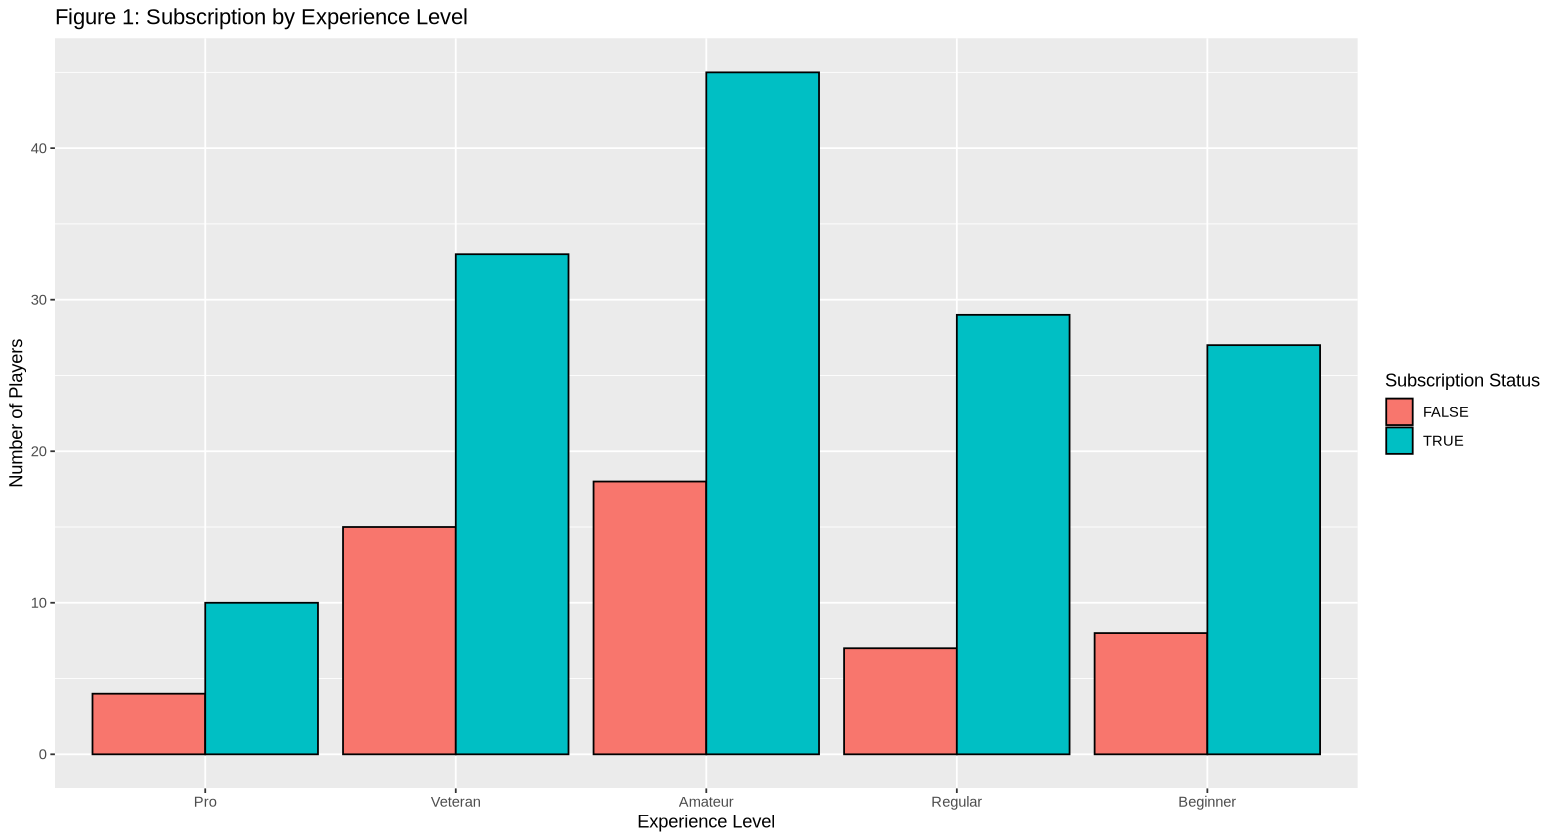

In [3]:
options(repr.plot.width = 13, repr.plot.height = 7) 

experience_vs_subscription <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge", color = "black") +
    labs(title = "Figure 1: Subscription by Experience Level",
         x = "Experience Level",
         y = "Number of Players",
         fill = "Subscription Status")

experience_vs_subscription

To examine whether experience level alone appears related to newsletter subscription, we calculated the proportion of subscribed players in each experience group. The quantitative analysis validates the patterns depicted in the bar chart.

In [4]:
subscription_rates <- players |>
  group_by(experience) |>
  summarise(subscribed = sum(subscribe == TRUE), 
        total = n(),
        proportion_subscribed = subscribed / total)

subscription_rates

experience,subscribed,total,proportion_subscribed
<fct>,<int>,<int>,<dbl>
Pro,10,14,0.7142857
Veteran,33,48,0.6875000
Amateur,45,63,0.7142857
Regular,29,36,0.8055556
Beginner,27,35,0.7714286


To illustrate these proportions more clearly, we plotted the subscription rate for each experience level.

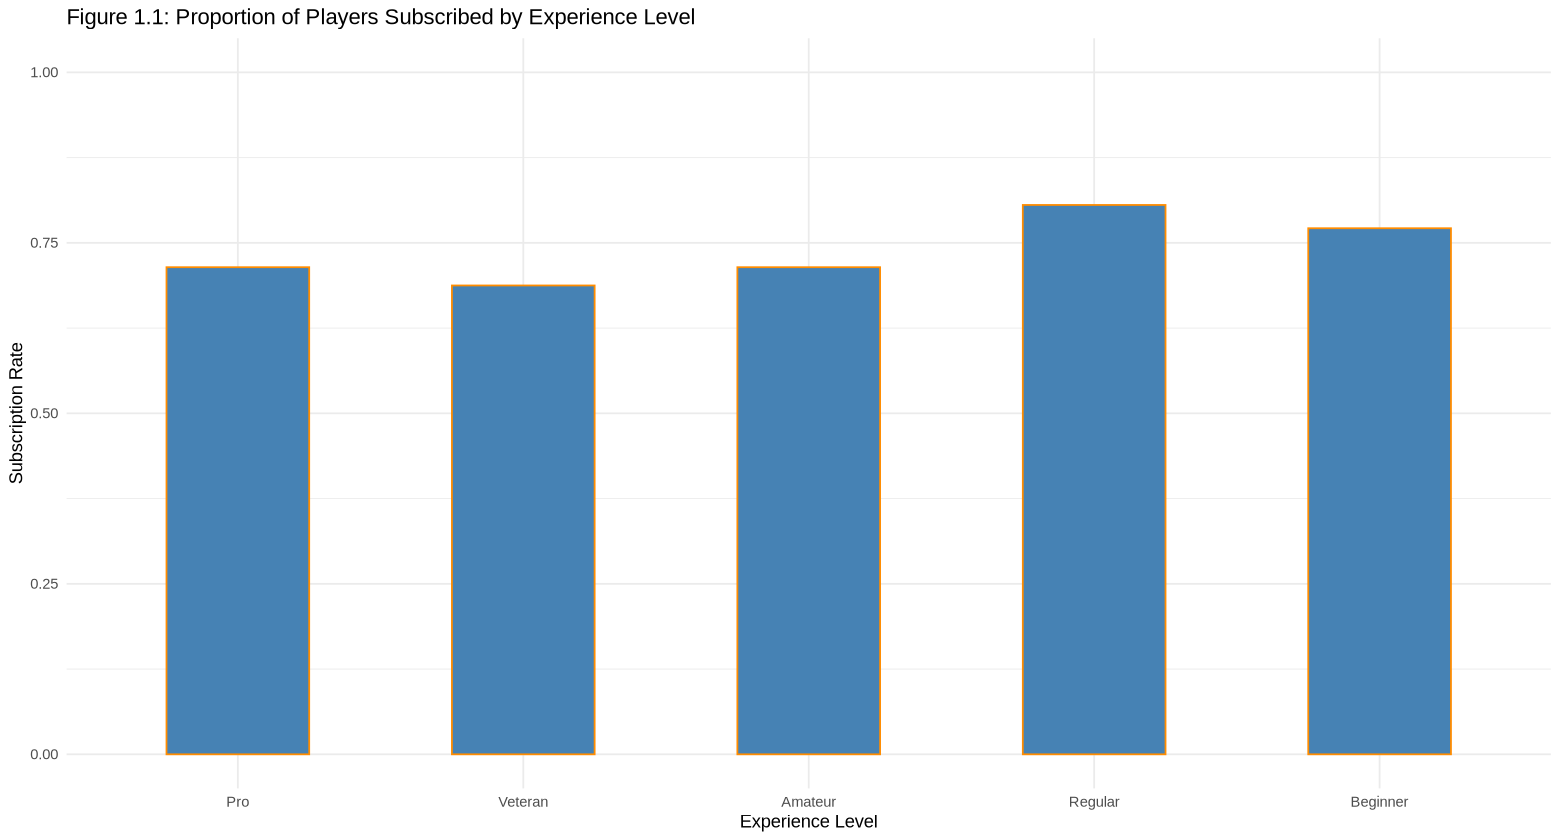

In [5]:
subscription_proportion_plot <- ggplot(subscription_rates, aes(x = experience, y = proportion_subscribed)) +
  geom_col(fill = "steelblue", color = "darkorange", width = 0.5) +
  labs(title = "Figure 1.1: Proportion of Players Subscribed by Experience Level",
          x = "Experience Level",
          y = "Subscription Rate") +
  ylim(0, 1) +
  theme_minimal(base_size = 11)

subscription_proportion_plot

The exploratory visualization (subscription_rates) shows clear differences in subscription patterns across experience levels. Amateur and Beginner players demonstrate lower subscription counts compared to Regular and Veteran players, which have higher subscription rates. Our plot (subscription_proportion_plot) reinforces these findings. We can see that subscription rates increase progressively with experience level, with Regular and Veteran players exhibiting the highest proportions of newsletter subscription. Pro players show moderate engagement, falling between some of the less-experienced and highly-experienced groups. What this means contextually is that these patterns mean that experience level is associated with newsletter subscription frequency.

There's a pretty interesting trend here showing that subscription rates climb as players get more experienced. While Amateurs and Beginners aren't really subscribing, Regular and Veteran players are signing up at much higher rates. These findings were somewhat expected, as more experienced players typically invest more time and interest in a game, making them more likely to subscribe in order to stay informed about updates, community events, or additional content. In the broader context of the UBC PLAI specifically, understanding how player experience relates to newsletter engagement can better inform marketing strategies, such as better segmentation, and enable them to target newer players with onboarding incentives that may boost early subscription rates. Tailoring newsletter content for high-experience players could also increase retention. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


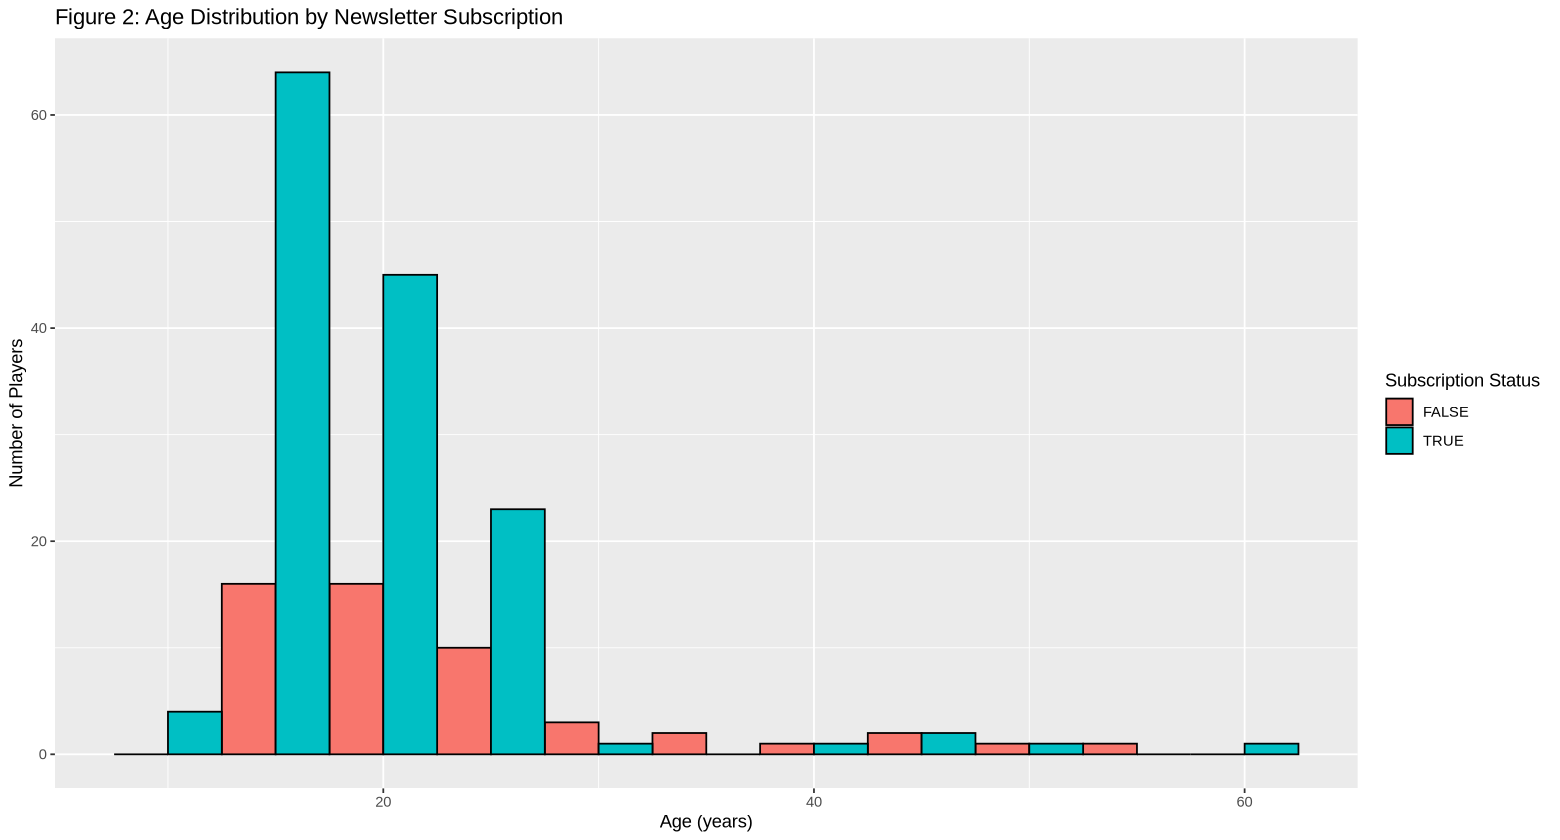

In [6]:
options(repr.plot.width = 13, repr.plot.height = 7) 

distribution_vs_subscription <- ggplot(players, aes(x = Age, fill = subscribe)) +
    geom_histogram(position = "dodge", binwidth = 5, color = "black") +
    labs(title = "Figure 2: Age Distribution by Newsletter Subscription",
         x = "Age (years)",
         y = "Number of Players",
         fill = "Subscription Status")

distribution_vs_subscription

Figure 2 shows a histogram comparing the age distribution of players who subscribed to a game-related newsletter (shown in blue), with players who did not subscribe (shown in red). Generally, the distribution shows a broad age range from around age 10 to over 60 years old; the plot also demonstrates that the distribution is highly right-skewed, with the majority of players being between roughly 13 to 25 years old. This concentration of younger players is expected, as Minecraft is highly popular among teens and young adults.

A key observation from the figure is that subscribed players consistently outnumber non-subscribed players across most age groups, which indicates that overall, the sample has a high subscription-rate. The most significant difference appears in the 15 - 25 age range, as the histogram bars representing subscribed players are substantially taller; this pattern suggests that younger players may be more willing or motivated to opt into newsletters, possibly due to better knowledge of online communication forms, or higher engagement with related content.

The non-subscribed group also has a significant presence in younger age groups, but their counts are noticeably lower compared to the subscribed group. This contrast suggests that age can be a meaningful predictor of subscription status. Additionally, the distribution of older players (above age 30), is relatively sparse; for these age groups, the subscriber and non-subscriber counts are low and roughly comparable, which limits the reliability of age as a predictor for subscription status.

Overall, Figure 2 suggests that subscription status may be dependent on age, with younger players being more likely to subscribe. However, the relationship does not appear to be strictly linear, so further modelling is needed to determine whether age is a significant predictor once additional variables are considered.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


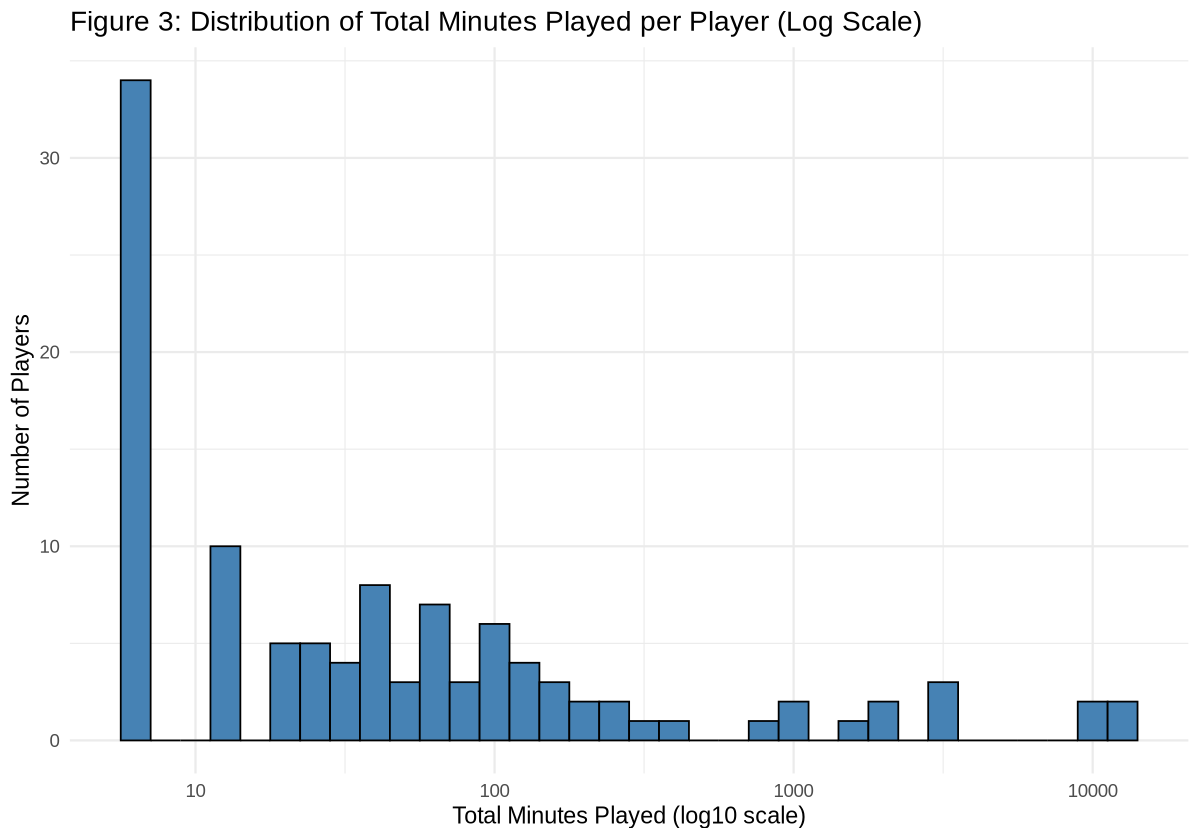

In [7]:
options(repr.plot.width = 10, repr.plot.height = 7)

minutes_played_plot <- ggplot(players, aes(x = played_minutes)) +
    geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
    scale_x_log10() +
    labs(
        title = "Figure 3: Distribution of Total Minutes Played per Player (Log Scale)",
        x = "Total Minutes Played (log10 scale)",
        y = "Number of Players"
    ) +
    theme_minimal(base_size = 14)

minutes_played_plot

Figure 3 is a histogram that shows the distribution of total minutes played by each player on a logarithmic scale for the x-axis. We use the log10 scale because it helps address the extreme right-skew in the original raw data, where a small number of players have very high playtime, and it makes it easier to visualise patterns in the data.

The plot shows a highly skewed distribution, as the majority of players have low total minutes played. On the left of the graph, there is a peak that indicates most players are clustered in the lower range, at under 10 minutes in the log10 scale. As the total minutes increase, the frequency of players drops sharply, which suggests that few players have high amounts of playtime. This pattern suggests that most players have limited engagement with the game, while a few players are highly active, which is seen from the long tail on the right. Players with higher total minutes are more likely to be familiar with the game environment and community, and therefore may be more likely to subscribe to a game-related newsletter. On the other hand, players with minimal playtime may have only briefly interacted with the server, so are not familiar or engaged enough to subscribe. Combining the above reasons, this visualisation suggests that total played minutes is likely a strong predictor of newsletter subscription.

## Analysis


#### Part 1: Splitting Data
Now that our data is wrangled according to our requirements, we may proceed with the analysis. To begin the classification, we will separate the dataset into a training set and testing set using a 75/25 split. So, 75% of the dataset will be used in the training process, while the remaining 25% will remain anonymous during training. The unseen data will be used to evaluate the final model's performance by computing classification metrics such as accuracy. In addition, a seed is set to ensure the reproducibility of our analysis, and to maintain a level of consistency throughout.

In [8]:
set.seed(1234)

players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split) |>
    filter(!is.na(Age))
players_test <- testing(players_split)

#### Part 2: Finding Best K-Nearest Neighbours Value

In order to maximize our model's performance on data it has not seen, it is important to identify an optimal k-value to be used for the k-nearest neighbour classification. So, we will apply the concept of cross-validation to evaluate the model's predictive performance across multiple k-values. 

----------------------------------------------------------------------------------------------------------------------------------------

To start this process, we will create a recipe using the `recipe` function and __players_train__ dataset. In particular, this analysis will focus on whether the `experience`, `Age`, and `played_minutes` can accurately predict `subscribe` status. As the KNN algorithm classifies observations based on the distance between points, it is absolutely necessary to scale and center all predictor variables to negate possible biases created by large-scale values.


In [9]:
set.seed(1)
players_recipe <- recipe(subscribe ~ experience + Age + played_minutes, data = players_train) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

Having completed the preprocessing of data and splitting the `players` dataset, we can create our K-nearest neighbours model specification using only the training dataset. This will be done using the `nearest_neighbor` function in R. Rather than specifying a value for the `neighbours` parameter, we will set it to `tune()` as we are yet to know the most optimal k-value. The model created will be assigned to a variable named `knn_spec1`.

In [10]:
knn_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec1

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we will use the `vfold_cv` function to perform the cross-validation. This function allows us to set the number of folds to be created on the training dataset, as well as the stratification variable (subscribe), ensuring that class proportions are preserved across each fold.

In [11]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

Now we will perform a workflow analysis using the preprocessing recipe (`players_recipe`) and k-nearest neighbours model specification (`knn_spec`) we created earlier. The model is tuned using the `tune_grid` function over a specified range of possible k-values, which is stored in the `k_vals` variables. Specifically, values of k will be tested from 1 to 10 (incremented by 1) and evaluated through cross-validation. The data table containing the metrics of the cross-validation will be assigned to the variables `knn_results`. 

In [12]:
set.seed(2)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec1) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5800821,5,0.04104615,Preprocessor1_Model01
1,roc_auc,binary,0.4931818,5,0.03215777,Preprocessor1_Model01
2,accuracy,binary,0.5936453,5,0.03542009,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.6086773,5,0.03632661,Preprocessor1_Model09
10,accuracy,binary,0.7516092,5,0.01315377,Preprocessor1_Model10
10,roc_auc,binary,0.5856177,5,0.03225670,Preprocessor1_Model10


Looking at the data table, we can see various columns containing important metrics that were collected through the workflow analysis; each row corresponding to a value of k that was evaluated in the analysis. Though, it is difficult to interpret what exactly we are meant to deduce from the new dataset. We have to remind ourselves that our goal for this section of the analysis is to figure out the most appropriate value of k that yields the best performance for our model. To achieve this, we can create a plot of the accuracy estimate against k-value being evaluated. From this plot, we will be able to observe the variations in accuracy as the k-value increases, allowing us to identify values of k that yield a high accuracy estimate.

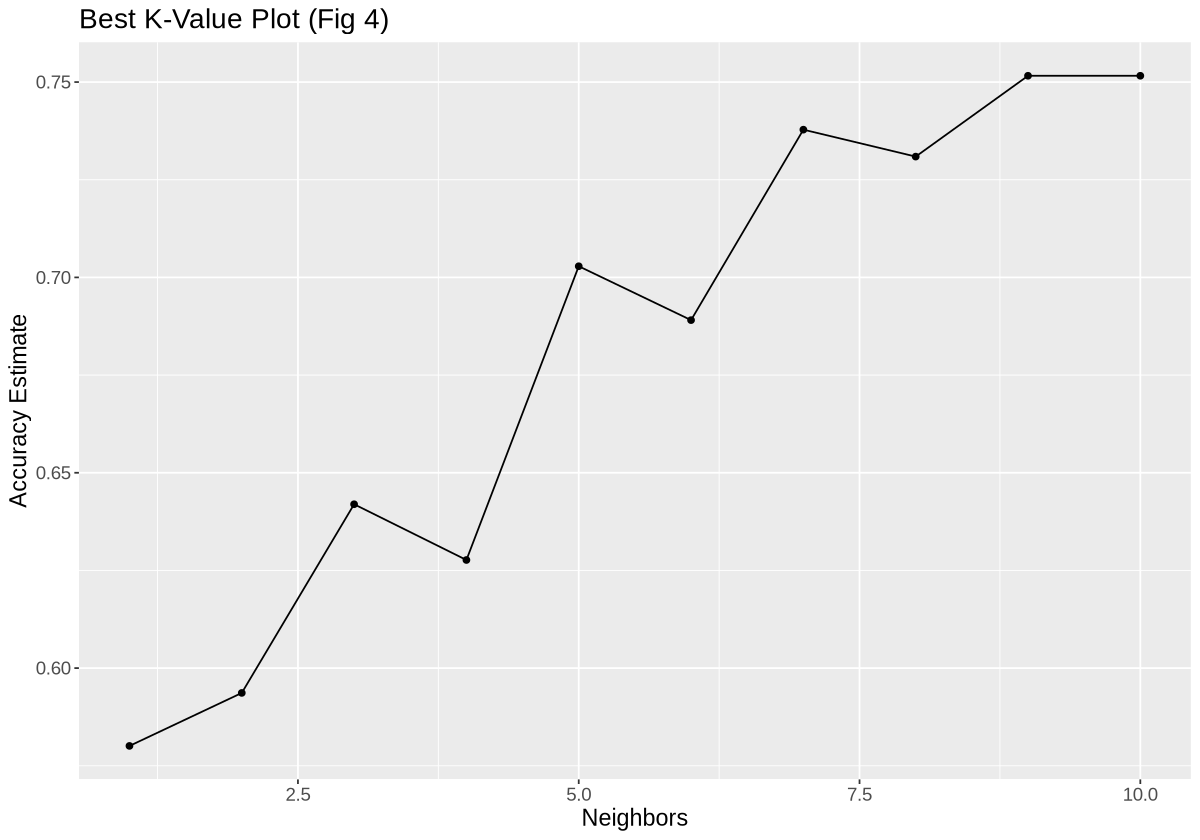

In [13]:
set.seed(123)
options(repr.plot.width = 10, repr.plot.height = 7)

accuracies <- knn_results |> filter(.metric == "accuracy") 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Best K-Value Plot (Fig 4)") +
    theme(text = element_text(size = 14))

accuracy_versus_k

Looking at the plot, we can see that the highest accuracy is observed when k is approximately 9. To confirm the exact value, we can arrange __accuracies__ dataset created earlier to order the `mean` column from highest to lowest. After, we can extract the k-value in the first row to obtain the exact number we are looking for. Running the cell below will produce the best k-value for our model.

In [14]:
best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

[1] 9

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Part 3: Performing Analysis with Best-K Value

Now that we have obtained the most optimal k-value to use in our model, a final KNN model will be trained using this value. We will start by creating a new specification called `knn_spec2` using the  `nearest_neighbor` function. Although, this time we will specify the "neighbors" parameter to be set equal to 9 in order to ensure that we yield the best possible results.

In [15]:
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

We will now conduct a new workflow (using the `workflow` function) analysis using the previously made recipe (`players_recipe`) and the new classification model `knn_spec2`. Once again, it is extremely important to fit the workflow using the training data set as we would like our model to be evaluated fairly and realistically on unseen data. 

Run the cell below to create the new workflow.

In [16]:
knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec2) |>
  fit(data = players_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 9

Finally, we can use the workflow we created in the previous step and make predictions on the __players_test__ dataset. This will be done using the `predict` function in R. This function accepts a trained model (`knn_fit`) to generate predictions on new data (`players_test`). We can then produce a data table containing metrics that represent the effectiveness of the model we created.

Run the cell below to view the accuracy, precision, and recall of our model

In [17]:
players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")
players_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7391304


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9444444


Looking at this, we can view the following metrics regarding our model:
   
    Accuracy = 71.4%
    Precision = 73.9%
    Recall = 94.4%

We can create a confusion matrix to display the prediction statistics produced by our model. Run the cell below to produce the matrix

In [18]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34

Our model demonstrates a high recall of 94.4%, displaying its strong ability to correctly identify positive instances in subscription status. In addition, the precision is at a reasonable range of 73.9%, meaning that a substantial proportion of predicted true subscribers are actually subscribed to the newsletter. Overall, our model prioritizes minimizing false negatives, though, it is done at the cost of increased false positives. This can be seen in the confusion matrix created above.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Discussion 

All in all, our analysis suggests that more experienced, younger, and higher playtime individuals are much more likely to subscribe to the Minecraft newsletter, and a tuned k-nn classifier using variables such as experience, age, and played minutes can predict subscription status with a reasonable level of accuracy. Our exploratory analysis indicated that subscription rates rise with experience level, as Regular and Veteran players have stronger engagement than Amateurs or Beginners. Age distributions skew young, with subscribers outnumbering non-subscribers in this range, while played minutes is skewed to the right. Our k-nn model, which is trained on a 75/25 split with scaled and centered predictors, tunes k through a 5-fold cross-validation over values 1~10, yielding the highest mean accuracy of 71.4%. This aligns with our initial expectations, since younger age groups are predominant and higher subscription rates among teens correspond with Minecraft’s core player demographic.

Our confusion matrix showed that our tuned knn model is accurate at identifying subscribers, but not as accurate at identifying non-subscribers. There are 12 false positives and 34 true positives, which gives us a 71.4% accuracy. This suggests that our model is not reliable for screening out disengaged players, since most non‑subscribers are misclassified as subscribers.

Overall, our findings enable the UBC research group to better segment players for targeted marketing purposes, prioritizing incentives for Beginners and Amateurs to boost early engagement and retention. To take it a step further, the data could potentially be used for advanced gaming analytics, and balance higher engagement veterans with onboarding for Minecraft newbies. 

Some key extensions or areas we can look at are correlations between other variables such as a player’s preferred “game mode” or the “frequency” or “duration” a player spends on the Minecraft server with their likelihood of subscribing. Lastly, a logistic regression could also be utilized in parallel to our k-nn to enhance accuracy. 